## Using Scikit-Learn and NLTK to build a Naive Bayes Classifier that identifies subtweets

#### In all tables, assume:
* "➊" represents a single URL
* "➋" represents a single mention of a username (e.g. "@noah")
* "➌" represents a single mention of an English first name 

#### Import libraries

In [1]:
%matplotlib inline

In [2]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from os.path import basename, splitext
from random import choice, sample
from nltk.corpus import stopwords
from string import punctuation
from pprint import pprint
from glob import glob

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import scipy.stats
import itertools
import enchant
import nltk
import json
import re

#### Set up some regex patterns

In [3]:
urls_pattern = re.compile(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?\xab\xbb\u201c\u201d\u2018\u2019]))')

In [4]:
at_mentions_pattern = re.compile(r'(?<=^|(?<=[^a-zA-Z0-9-\.]))@([A-Za-z0-9_]+)')

In [5]:
names = open("../data/other_data/first_names.txt").read().split("\n")
names_pattern = re.compile(r'\b(?:{})\b'.format('|'.join(names)))

#### Prepare English dictionary for language detection

In [6]:
english_dict = enchant.Dict("en_US")

#### Use NLTK's tokenizer instead of Scikit's

In [7]:
tokenizer = nltk.casual.TweetTokenizer()

#### Prepare for viewing long text in CSVs and ones with really big and small numbers

In [8]:
pd.set_option("display.height", 1000)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.set_option("max_colwidth", 1000)

In [9]:
pd.options.display.float_format = "{:.4f}".format

#### Load the two data files
#### Only use tweets with at least 10% English words
#### Also, make the mentions of usernames, names, and URLs generic

In [10]:
def load_data(filename, threshold=0.1):
    data = [(urls_pattern.sub("➊", 
             at_mentions_pattern.sub("➋", 
             names_pattern.sub("➌",
             t["tweet_data"]["full_text"])))
             .replace("\u2018", "'")
             .replace("\u2019", "'")
             .replace("\u201c", "\"")
             .replace("\u201d", "\"")
             .replace("&quot;", "\"")
             .replace("&amp;", "&")
             .replace("&gt;", ">")
             .replace("&lt;", "<")) 
            for t in json.load(open(filename)) 
            if t["tweet_data"]["lang"] == "en" 
            and t["reply"]["lang"] == "en" 
            and t["tweet_data"]["user"]["lang"] == "en" 
            and t["reply"]["user"]["lang"] == "en"]
    new_data = []
    for tweet in data:
        tokens = tokenizer.tokenize(tweet)
        english_tokens = [english_dict.check(token) for token in tokens]
        percent_english_words = sum(english_tokens)/len(english_tokens)
        if percent_english_words >= threshold:
            new_data.append(tweet)
    return new_data

In [11]:
subtweets_data = load_data("../data/other_data/subtweets.json")

In [12]:
non_subtweets_data = load_data("../data/other_data/non_subtweets.json")

#### Remove tweets which are present in both datasets

In [13]:
subtweets_data = [tweet for tweet in subtweets_data if tweet not in non_subtweets_data]

CPU times: user 10.5 s, sys: 149 ms, total: 10.6 s
Wall time: 11.1 s


In [14]:
non_subtweets_data = [tweet for tweet in non_subtweets_data if tweet not in subtweets_data]

CPU times: user 10.1 s, sys: 263 ms, total: 10.4 s
Wall time: 13.9 s


#### Show examples

In [15]:
print("Subtweets dataset example:")
for _ in range(10):
    print(choice(subtweets_data))

Subtweets dataset example:
The next straight cisgender white middle class dude that discovered socialism the minute he realized he wasn't gonna make the money he thought he was tells me I don't care about social justice is gonna get a copy of Das Kapital shoved up their ass.
I think she know! ➊
Don't be this person. ➊
Support your local library or chuck_wendig will release the ants. @ Los Osos Library ➊
Isn't it crazy how we are in our mid twenties and some people still act like they're in high school? All I'm saying is grow a pair and say what you have to say 🤭
y'all talk a lot of shit on the president but he's the commander in chief lol try to fight him he'll just launch a missile at you idiot
TFW you think Bears has mistaken our departure time by 2 hours.....
@ people who leave group chats almost instantly: Why are you so boring and bitter
I think this is the first time I've ever turned off somebody's retweets, holy cow. No more Ragna, Goku, Raven, w/e. sheesh
The worst thing you ca

In [16]:
print("Non-subtweets dataset example:")
for _ in range(10):
    print(choice(non_subtweets_data))

Non-subtweets dataset example:
➌ ➌ "All these years the UK fighters had to go to America. We can do it in London. Wembley. Cardiff. It's local. We are staying right here. I want Wilder next or Fury. Either one".
WATCH: Eagles of Death Metal frontman apologizes after calling March For Our Lives students "pathetic" ➊ ➊
Well that sealed it HRC endorsed ➋ Fight for progress just another slogan - I can't take any more of these Centrist A** hole$ !! ➊
➋ happy birthday superstar 🎈
every time hatok makes a jab at 14, i die a little inside knowing its the best modern final fantasy experience

CHANGE MY MIND
Thanks ➋ for the birthday gift. And use some rewards points ➊
My son was born today welcome to tha #GramKillers 💪🏾💪🏾💪🏾
Half way through the first day of qualifying matches and our Drive Team is doing a great job! We may be rookies but we don't play like it! #frcnyli #sobotz #team6911 ➊
These companies pulled their ads from ➋. I call for them to  reinstate the ads and do what it is right. Sho

#### Find the length of the smaller dataset

In [17]:
smallest_length = len(min([subtweets_data, non_subtweets_data], key=len))

#### Cut both down to be the same length

In [18]:
subtweets_data = sample(subtweets_data, smallest_length)

In [19]:
non_subtweets_data = sample(non_subtweets_data, smallest_length)

In [20]:
print("Smallest dataset length: {}".format(len(subtweets_data)))

Smallest dataset length: 11288


#### Prepare data for training

In [21]:
subtweets_data = [(tweet, "subtweet") for tweet in subtweets_data]

In [22]:
non_subtweets_data = [(tweet, "non-subtweet") for tweet in non_subtweets_data]

#### Combine them

In [23]:
training_data = subtweets_data + non_subtweets_data

#### Build the pipeline

In [24]:
sentiment_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=tokenizer.tokenize, 
                                   ngram_range=(1, 3), 
                                   stop_words="english")),
    ("classifier", MultinomialNB())
])

#### K-Folds splits up and separates out 10 training and test sets from the data, from which the classifier is trained and the confusion matrix and classification reports are updated

In [25]:
def confusion_matrices(training_data, num_folds=10):
    text_training_data = np.array([row[0] for row in training_data])
    class_training_data = np.array([row[1] for row in training_data])
    kf = KFold(n_splits=num_folds, random_state=42, shuffle=True)
    
    cnf_matrix_test = np.zeros((2, 2), dtype=int)
    cnf_matrix_train = np.zeros((2, 2), dtype=int)
    
    test_reports = []
    train_reports = []
    
    test_accuracies = []
    train_accuracies = []
    for i, (train_index, test_index) in enumerate(kf.split(text_training_data)):

        text_train, text_test = text_training_data[train_index], text_training_data[test_index]
        class_train, class_test = class_training_data[train_index], class_training_data[test_index]

        sentiment_pipeline.fit(text_train, class_train)
        
        predictions_test = sentiment_pipeline.predict(text_test)
        predictions_train = sentiment_pipeline.predict(text_train)

        cnf_matrix_test += confusion_matrix(class_test, predictions_test)
        cnf_matrix_train += confusion_matrix(class_train, predictions_train)

        print("Test Data Iteration {}:".format(i+1))
        
        test_report = classification_report(class_test, predictions_test, digits=4)
        test_reports.append(test_report)
        print(test_report)
                
        test_accuracy = accuracy_score(class_test, predictions_test)
        test_accuracies.append(test_accuracy)
        print("Test Data Accuracy: {:.4f}\n".format(test_accuracy))
        print("="*53)
        
        print("Train Data Iteration {}:".format(i+1))
        
        train_report = classification_report(class_train, predictions_train, digits=4)
        train_reports.append(train_report)
        print(train_report)
                
        train_accuracy = accuracy_score(class_train, predictions_train)
        train_accuracies.append(train_accuracy)
        print("Train Data Accuracy: {:.4f}\n".format(train_accuracy))
        print("="*53)
        
    def reports_mean(reports):
        reports_lists_of_strings = [report.split("\n") for report in reports]
        reports = [[[float(e) for e in report_string[2][16:].split()],
                    [float(e) for e in report_string[3][16:].split()],
                    [float(e) for e in report_string[5][16:].split()]]
                   for report_string in reports_lists_of_strings]
        mean_list = np.mean(np.array(reports), axis=0).tolist()
        print("              precision    recall  f1-score   support")
        print()
        print("non-subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[0][0], 
                                                                                 mean_list[0][1], 
                                                                                 mean_list[0][2], 
                                                                                 int(mean_list[0][3])))
        print("    subtweet     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[1][0], 
                                                                                 mean_list[1][1], 
                                                                                 mean_list[1][2], 
                                                                                 int(mean_list[1][3])))
        print()
        print(" avg / total     {0:.4f}    {1:.4f}    {2:.4f}      {3:d}".format(mean_list[2][0], 
                                                                                 mean_list[2][1], 
                                                                                 mean_list[2][2], 
                                                                                 int(mean_list[2][3])))
        print()
        print("="*53)
    
    print("Test Data Averages Across All Folds:")
    reports_mean(test_reports)
    
    print("Train Data Averages Across All Folds:")
    reports_mean(train_reports)
    
    return {"Test": cnf_matrix_test, "Train": cnf_matrix_train}

In [26]:
cnf_matrices = confusion_matrices(training_data)
cnf_matrix_test = cnf_matrices["Test"]
cnf_matrix_train = cnf_matrices["Train"]

Test Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.7046    0.7111    0.7079      1087
    subtweet     0.7295    0.7233    0.7264      1171

 avg / total     0.7176    0.7174    0.7175      2258

Test Data Accuracy: 0.7174

Train Data Iteration 1:
              precision    recall  f1-score   support

non-subtweet     0.9812    0.9870    0.9841     10201
    subtweet     0.9868    0.9809    0.9838     10117

 avg / total     0.9840    0.9840    0.9840     20318

Train Data Accuracy: 0.9840

Test Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.7160    0.7063    0.7111      1103
    subtweet     0.7231    0.7325    0.7277      1155

 avg / total     0.7196    0.7197    0.7196      2258

Test Data Accuracy: 0.7197

Train Data Iteration 2:
              precision    recall  f1-score   support

non-subtweet     0.9807    0.9849    0.9828     10185
    subtweet     0.9847    0.9806    0.9826     10133



#### See the most informative features
[How does "MultinomialNB.coef_" work?](https://stackoverflow.com/a/29915740/6147528)

In [27]:
def most_informative_features(pipeline, n=15000):
    vectorizer = pipeline.named_steps["vectorizer"]
    classifier = pipeline.named_steps["classifier"]
    
    class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    
    top_n_class_1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    top_n_class_2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]
    
    return {class_labels[0]: pd.DataFrame({"Log Probability": [tup[0] for tup in top_n_class_1], 
                                           "Feature": [tup[1] for tup in top_n_class_1]}), 
            class_labels[1]: pd.DataFrame({"Log Probability": [tup[0] for tup in reversed(top_n_class_2)],
                                           "Feature": [tup[1] for tup in reversed(top_n_class_2)]})}

In [28]:
most_informative_features_all = most_informative_features(sentiment_pipeline)

CPU times: user 2.01 s, sys: 33.6 ms, total: 2.04 s
Wall time: 2.05 s


In [29]:
most_informative_features_non_subtweet = most_informative_features_all["non-subtweet"]

In [30]:
most_informative_features_subtweet = most_informative_features_all["subtweet"]

In [31]:
final_features = most_informative_features_non_subtweet.join(most_informative_features_subtweet, 
                                                             lsuffix=" (Non-subtweet)", 
                                                             rsuffix=" (Subtweet)")
final_features.to_csv("../data/other_data/most_informative_features.csv")
final_features.head(50)

,Feature (Non-subtweet),Log Probability (Non-subtweet),Feature (Subtweet),Log Probability (Subtweet)
0,! ! #absapremiership,-13.0606,.,-7.6610
1,! ! #b2b,-13.0606,",",-8.0238
2,! ! #beredseered,-13.0606,➊,-8.0423
3,! ! #cholecystectomy,-13.0606,"""",-8.1517
4,! ! #fbr,-13.0606,people,-8.4336
5,! ! #free,-13.0606,?,-8.5699
6,! ! #frustrated,-13.0606,don't,-8.6773
7,! ! #ipl2018,-13.0606,like,-8.6839
8,! ! #liars,-13.0606,just,-8.7258
9,! ! #lottedutyfreexbts,-13.0606,i'm,-8.8254


#### Define function for visualizing confusion matrices

In [32]:
def plot_confusion_matrix(cm, classes=["non-subtweet", "subtweet"], 
                          title="Confusion Matrix", cmap=plt.cm.Purples):
    
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    
    plt.title(title, size=18)
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{} ({:.0%})".format(cm[i, j], cm_normalized[i, j]),
                horizontalalignment="center", size=16,
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    
    plt.ylabel("True label", fontsize=14)
    plt.xlabel("Predicted Label", fontsize=14)

#### Show the matrices

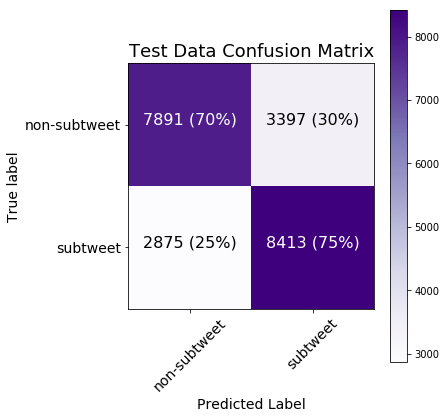

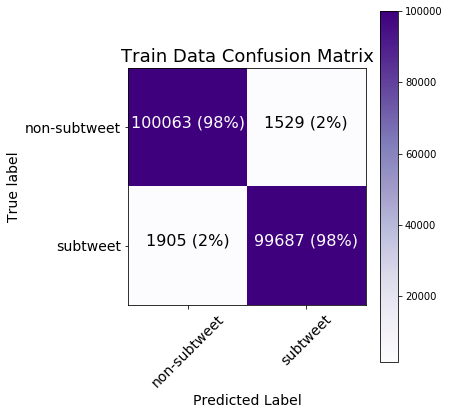

In [33]:
np.set_printoptions(precision=2)

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_test, title="Test Data Confusion Matrix")

plt.figure(figsize=(6, 6))
plot_confusion_matrix(cnf_matrix_train, title="Train Data Confusion Matrix")

plt.show()

#### Update matplotlib style

In [34]:
plt.style.use("fivethirtyeight")

#### Save the classifier for another time

In [35]:
joblib.dump(sentiment_pipeline, "../data/other_data/subtweets_classifier.pkl");

#### Print tests for the classifier

In [36]:
def process_tweets_for_testing(filenames):
    dataframes = {}
    for filename in filenames:
        username = splitext(basename(filename))[0][:-7]
        dataframes[username] = {}
        
        user_df = pd.read_csv(filename).dropna()
        user_df["Text"] = user_df["Text"].str.replace(urls_pattern, "➊")
        user_df["Text"] = user_df["Text"].str.replace(at_mentions_pattern, "➋")
        user_df["Text"] = user_df["Text"].str.replace(names_pattern, "➌")
        user_df["Text"] = user_df["Text"].str.replace("\u2018", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u2019", "'")
        user_df["Text"] = user_df["Text"].str.replace("\u201c", "\"")
        user_df["Text"] = user_df["Text"].str.replace("\u201d", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&quot;", "\"")
        user_df["Text"] = user_df["Text"].str.replace("&amp;", "&")
        user_df["Text"] = user_df["Text"].str.replace("&gt;", ">")
        user_df["Text"] = user_df["Text"].str.replace("&lt;", "<")
        
        predictions = sentiment_pipeline.predict_proba(user_df["Text"])[:, 1].tolist()
        user_df["SubtweetProbability"] = predictions

        dataframes[username]["all"] = user_df
        
        scores = user_df[["SubtweetProbability"]].rename(columns={"SubtweetProbability": username})
        
        dataframes[username]["scores"] = scores
        dataframes[username]["stats"] = scores.describe()
        
    return dataframes

#### Load the CSV files

In [37]:
filenames = glob("../data/data_for_testing/friends_data/*.csv")

In [38]:
dataframes = process_tweets_for_testing(filenames)

CPU times: user 9.48 s, sys: 183 ms, total: 9.66 s
Wall time: 10.2 s


#### Show a random table

In [39]:
chosen_username = choice(list(dataframes.keys()))
dataframes[chosen_username]["all"].sort_values(by="SubtweetProbability", ascending=False).head(5)

,Text,Date,Favorites,Retweets,Tweet ID,SubtweetProbability
270,herding cats only you're also a cat,2017-04-09 11:56:33,2,0,851101536944095232,0.7328
14,"*catches story about Far Cry 5 composer on NPR*\n\n""Oh cool""\n\n*NPR host proceeds to insult earlier generations of game composers while obviously knowing nothing about the medium*\n\n""...arschloch...""\n\n*composer tacitly agrees*\n\n*breaks radio*",2018-03-28 14:23:01,9,0,979061310695641088,0.7274
154,"i'm bored with twitter, let's look at twitter",2017-09-19 17:56:21,2,1,910261304711159808,0.7170
64,"wow, LINQ can be dangerously CPU hungry if you aren't careful (*sometimes* i'm not)",2018-01-14 20:30:49,0,0,952714658875457536,0.7064
96,"My new phone doesn't know me yet. When I type ""hellscape"" I mean ""hellscape,"" not ""Hillsdale""",2017-12-06 19:28:20,5,0,938565806719455232,0.6912


#### Prepare statistics on tweets

In [40]:
tests_df = pd.concat([df_dict["scores"] for df_dict in dataframes.values()], ignore_index=True)

In [41]:
test_df_stats = tests_df.describe()

In [42]:
test_df_stats.columns = ["User {}".format(i + 1) for i, column in enumerate(test_df_stats.columns)]

In [43]:
test_df_stats

,User 1,User 2,User 3,User 4,User 5,User 6,User 7,User 8,User 9,User 10,User 11,User 12,User 13,User 14
count,621.0000,2640.0000,2066.0000,3488.0000,4356.0000,1939.0000,1169.0000,638.0000,2814.0000,445.0000,772.0000,5364.0000,853.0000,1467.0000
mean,0.5198,0.5110,0.5621,0.5227,0.5312,0.4936,0.4296,0.5424,0.5169,0.4174,0.5506,0.5093,0.5556,0.5378
std,0.1187,0.1334,0.1211,0.1300,0.1090,0.1272,0.1155,0.1295,0.1230,0.1158,0.1214,0.1274,0.1246,0.1239
min,0.1162,0.0617,0.0912,0.0869,0.0637,0.0368,0.0195,0.1063,0.0330,0.0521,0.1355,0.0399,0.1186,0.0457
25%,0.4379,0.4252,0.4807,0.4298,0.4596,0.4158,0.3585,0.4568,0.4366,0.3536,0.4724,0.4264,0.4787,0.4687
50%,0.5219,0.5142,0.5592,0.5290,0.5336,0.4988,0.4322,0.5391,0.5230,0.4189,0.5475,0.5069,0.5530,0.5395
75%,0.6023,0.6005,0.6454,0.6179,0.6012,0.5752,0.5043,0.6323,0.5977,0.5002,0.6366,0.5918,0.6395,0.6238
max,0.8661,0.9078,0.8883,0.9049,0.9113,0.9018,0.8408,0.8874,0.8931,0.7328,0.8806,0.9067,0.8725,0.9007


#### Plot a histogram with three random users

[2640.0, 0.510974216440794, 0.1333750739119666, 0.06167070282863514, 0.42522095864796183, 0.5141759670853949, 0.6005047582561756, 0.9078269341439998]
[2814.0, 0.5168738021156133, 0.1229585539376188, 0.0330098917047056, 0.43660560090304806, 0.5229978405874081, 0.5977007670244899, 0.8931268586639309]
[5364.0, 0.5092823782982704, 0.12739269335236975, 0.039857144868322675, 0.42642798430433415, 0.5068758516607921, 0.5918282179395047, 0.9067181108055742]


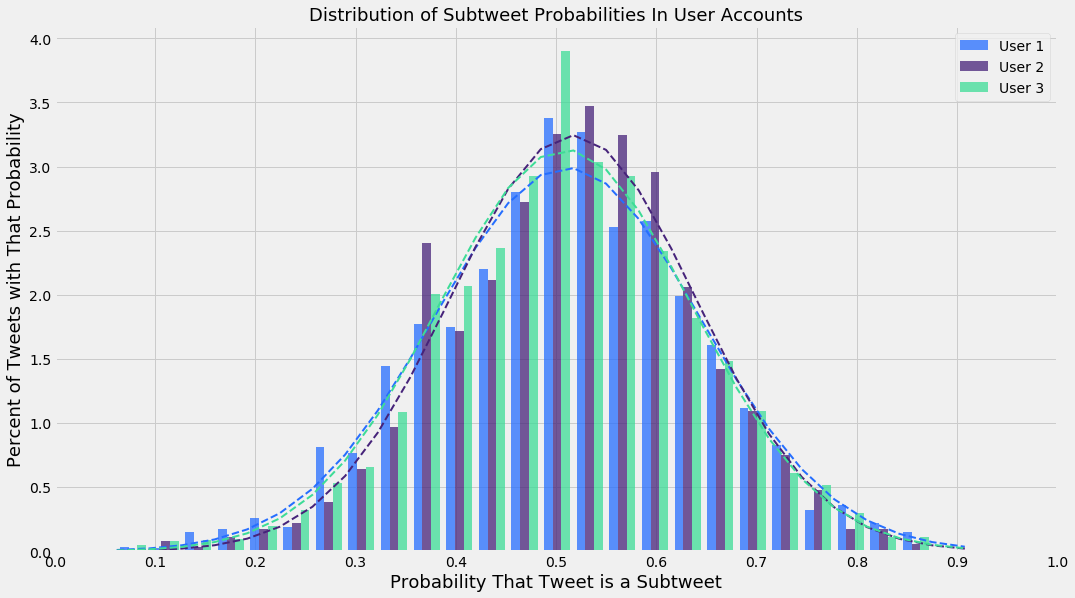

In [44]:
random_choices = sample(list(dataframes.values()), 3)
scores = [df_dict["scores"][df_dict["scores"].columns[0]].tolist() 
          for df_dict in random_choices]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(scores, 
                           bins="scott",
                           color=["#256EFF", "#46237A", "#3DDC97"],
                           density=True, 
                           label=["User 1", "User 2", "User 3"],
                           alpha=0.75)

stats = [df_dict["stats"][df_dict["stats"].columns[0]].tolist() 
         for df_dict in random_choices]
for e in stats:
    print(e)
line_1 = scipy.stats.norm.pdf(bins, stats[0][1], stats[0][2])
ax.plot(bins, line_1, "--", color="#256EFF", linewidth=2)

line_2 = scipy.stats.norm.pdf(bins, stats[1][1], stats[1][2])
ax.plot(bins, line_2, "--", color="#46237A", linewidth=2)

line_3 = scipy.stats.norm.pdf(bins, stats[2][1], stats[2][2])
ax.plot(bins, line_3, "--", color="#3DDC97", linewidth=2)

ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Plot a histogram with all of them
#### First, get some statistics

In [45]:
new_tests_df = pd.concat([df_dict["scores"].rename(columns={df_dict["scores"].columns[0]:"SubtweetProbability"})
                          for df_dict in dataframes.values()], ignore_index=True)

new_tests_df_stats = new_tests_df.describe()

#### Then view them

In [46]:
new_tests_df_stats

,SubtweetProbability
count,28632.0000
mean,0.5181
std,0.1267
min,0.0195
25%,0.4363
50%,0.5202
75%,0.6023
max,0.9113


#### Now plot

No handles with labels found to put in legend.


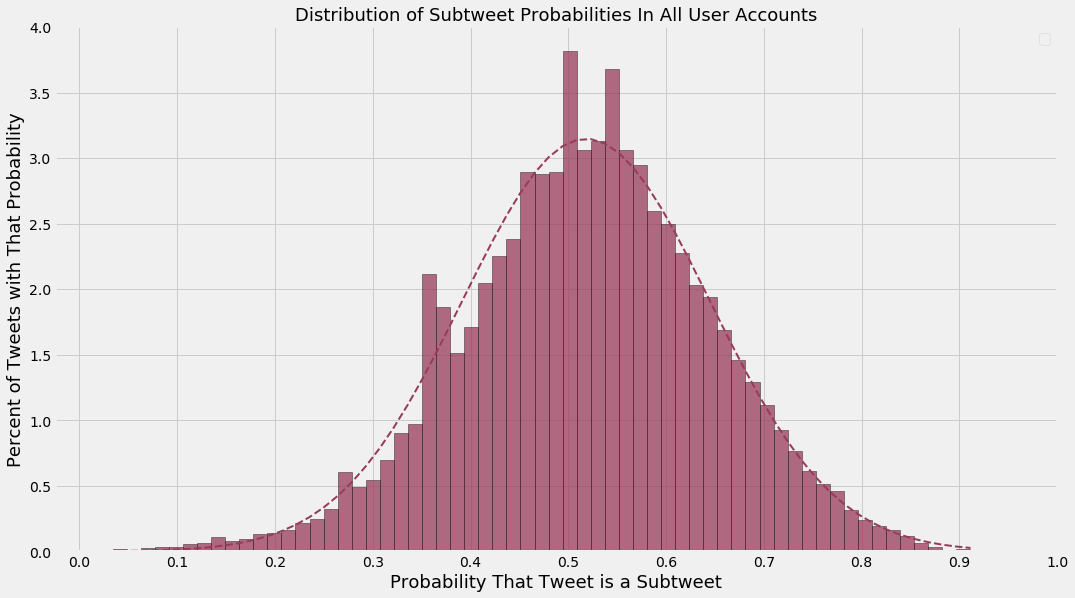

In [47]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(new_tests_df["SubtweetProbability"].tolist(), 
                           bins="scott",
                           color="#983B59",
                           edgecolor="black", 
                           density=True, 
                           alpha=0.75)

line = scipy.stats.norm.pdf(bins, new_tests_df_stats["SubtweetProbability"][1], 
                              new_tests_df_stats["SubtweetProbability"][2])

ax.plot(bins, line, "--", color="#983B59", linewidth=2)


ax.set_xticks([float(x/10) for x in range(11)], minor=False)
ax.set_title("Distribution of Subtweet Probabilities In All User Accounts", fontsize=18)
ax.set_xlabel("Probability That Tweet is a Subtweet", fontsize=18)
ax.set_ylabel("Percent of Tweets with That Probability", fontsize=18)

ax.legend()

plt.show()

#### Statisitics on training data

#### Remove mentions of usernames for these statistics

In [48]:
training_data = [(tweet[0]
                  .replace("➊", "")
                  .replace("➋", "")
                  .replace("➌", "")) for tweet in training_data]

#### Lengths

In [49]:
length_data = [len(tweet) for tweet in training_data]

In [50]:
length_data_for_stats = pd.DataFrame({"Length": length_data, "Tweet": training_data})

In [51]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] <= 280]  

In [52]:
# length_data_for_stats = length_data_for_stats[length_data_for_stats["Length"] >= 5]

In [53]:
length_data = length_data_for_stats.Length.tolist()

#### Top 5 longest tweets

In [54]:
length_data_for_stats.sort_values(by="Length", ascending=False).head()

,Length,Tweet
13533,281,The previous occupant of this house was a 90 yr old Japanese-American widow. Everything's 70s af. Harvest gold in the kitchen. Shag carpet in the living room. Beads in the bathroom window. Fuzzy wallpaper in the entryway.\n\nAll this stuff is in amazing condition for how old it is.
12058,281,"Remember, when you lose your job, when you cant apply for that position in Europe, when your holiday money doesnt go as far as it used to, when you're stuck in the slow queue at the border,..\n\nRemember it wasnt anything concrete that actually happened..it was just..a 'principle'."
17162,281,"""Advisory equity @ 1-5% helps the mentor be aligned to the startup"" \n\nThis is insane crap! Advisory equity in early stage startups (if at all) shld be of order ~ 0.10% - 0.25%. Anything more means misaligned incentives.. the startup is either clueless or being taken for a ride!"
20907,281,"Keep in mind Trump is complaining about the seizure of documents he concedes were created without his knowledge, and thus outside any attorney-client relationship. So even Trump's four-word tweets are incoherent—unless this is a confession he DID know about the payoff to Daniels."
21273,281,"ARMY this is a serious issue and we are going address it including turning to the local police. We know it's not all of you, but a small group of haters. We need to make sure not to encourage that behavior, it against everything BTS, BigHit and ARMY stands for. Bully is not cool."


#### Top 5 shortest tweets

In [55]:
length_data_for_stats.sort_values(by="Length", ascending=True).head()

,Length,Tweet
7521,4,Fake
2405,4,Rude
10291,4,soft
4370,4,Lame
2538,4,Ugly


#### Tweet length statistics

In [56]:
length_data_for_stats.describe()

,Length
count,22576.0000
mean,103.7809
std,73.1875
min,4.0000
25%,46.0000
50%,83.0000
75%,145.0000
max,281.0000


#### Punctuation

In [57]:
punctuation_data = [len(set(punctuation).intersection(set(tweet))) for tweet in training_data]

In [58]:
punctuation_data_for_stats = pd.DataFrame({"Punctuation": punctuation_data, "Tweet": training_data})

#### Top 5 most punctuated tweets

In [59]:
punctuation_data_for_stats.sort_values(by="Punctuation", ascending=False).head()

,Punctuation,Tweet
4380,13,"IF U WERE KILLED TOMORROW, I WOULDNT GO 2 UR FUNERAL CUZ ID B N JAIL 4 KILLIN DA PERSON THAT KILLED U!\n......__________________ \n...../_==o;;;;;;;;______[]\n.....), —-.(_(__) / \n....// (..) ), —--"" \n...//___// \n..//___// \nWE TRUE HOMIES WE RIDE TOGETHER WE DIE TOGETHER"
12617,11,"Going to go ahead and crown myself the absolute emperor of finding things on menus that sound interesting, deciding I would like to try them, then being told ""I'm sorry sir, that's actually not available...""\n\n[ then why the @#$% is it ON YOUR MENUUUUUUUU-- ]"
15961,10,"10,000 #Fortnite V-Bucks Giveaway!\n 🔥$100.00 PayPal🔥\n\n1. Retweet This Tweet\n2. Follow & Myself\n3. Tag a friend for x2 Entry (optional)\n\nDrawing Winner in 48 Hours! \n(04/02/18) Good Luck!"
13815,10,"Hooray—for those of you who've been asking when FLASHBACK will be available for pre-order on *ebook* the answer is finally: NOW! Alas, pre-ordering won't make it come out sooner than 11/6 (still writing it, guys). BUT, it does make me super happy, so… 😉\n"
21165,10,"USA's share of global GDP was about 50% after WW2, today it is about 15%. It will further decline this century (although its economy & GDP/capita will continue to grow in absolute terms).\n\nHow will America react to this loss of ""relative power""? By all indications, rather badly."


#### Tweets punctuation statistics

In [60]:
punctuation_data_for_stats.describe()

,Punctuation
count,22576.0000
mean,1.9781
std,1.6262
min,0.0000
25%,1.0000
50%,2.0000
75%,3.0000
max,13.0000


#### Stop words

In [61]:
stop_words_data = [len(set(stopwords.words("english")).intersection(set(tweet.lower()))) 
                   for tweet in training_data]

In [62]:
stop_words_data_for_stats = pd.DataFrame({"Stop words": stop_words_data, "Tweet": training_data})

#### Top 5 tweets with most stop words

In [63]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=False).head()

,Stop words,Tweet
0,8,TWITTER SHOWED ME YOU HITTING THAT LIKE BUTTON ON THAT PORN\n\nI SEE YOU
9314,8,Point well made dude who only watches and reads things that already agree with you no matter how fringe or disproven. \nWhat's that? You consider challenging your beliefs with facts and data a sign of weakness?\nThen u have won this exchange!
17250,8,"The fact that Zuckerberg is a good person (true, as best I can tell) simply underscores the extent of the problem and why control over all this data and power can't simply be left in one person's hands."
17248,8,So I've been really sick again these last five or so days and I've felt miserable and it's making it really hard for me to want to take pictures when I feel so bleh 😔 so this is all I have for right now #trap #sissy #femboy #prettyboy
9225,8,weird how carly rae jepsen's E•MO•TION is the best soundtrack to any activity


#### Top 5 tweets with fewest stop words

In [64]:
stop_words_data_for_stats.sort_values(by="Stop words", ascending=True).head()

,Stop words,Tweet
2503,0,fuck u
9023,0,Fuck...
9510,0,𝓸𝓵𝓲𝓿𝓲𝓪'𝓼 𝕣𝕒𝕟𝕕𝕠𝕞 𝙦𝙪𝙚𝙨𝙩𝙞𝙤𝙣 𝙩𝙝𝙧𝙚𝙖𝙙.
6701,0,luv u
3655,0,We been knew


#### Tweets stop words statistics

In [65]:
stop_words_data_for_stats.describe()

,Stop words
count,22576.0000
mean,7.0969
std,1.3484
min,0.0000
25%,7.0000
50%,8.0000
75%,8.0000
max,8.0000


#### Unique words

In [66]:
unique_words_data = [len(set(tokenizer.tokenize(tweet))) for tweet in training_data]

In [67]:
unique_words_data_for_stats = pd.DataFrame({"Unique words": unique_words_data, "Tweet": training_data})

In [68]:
# unique_words_data_for_stats = unique_words_data_for_stats[unique_words_data_for_stats["Unique words"] >= 2]

In [69]:
unique_words_data = unique_words_data_for_stats["Unique words"].tolist()

#### Top 5 tweets with most unique words

In [70]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=False).head()

,Tweet,Unique words
2219,"I'm starting to get a couple questions about it since May is coming up so I might as well let you guys know: there will not be a MIAMAFV 2 this year (at least not that exact event).\n\nWho knows what's to come in the future, but right now I've got to take care of other stuff first.",59
16147,"GIVE AWAY!\n\nThe rules are really easy, all you have to do is :\n1. Must be following me (i check) \n2. RT and fav this tweet\n3. tag your mutuals/anyone\n4. only 1 winner! \n5. i ship worldwide;) \n\nit ends in 8th May 2018 or when this tweet hit 2k RT and like!\n\nGood luck! ❤",59
16280,"ur bday 21/8 u50. Fancy a kick about the park where we used to play.?Jumpers down- shots.Then 3 holes of golf.we hit any windows we run!What do u say- will be a laugh.I am 50 a week later.hey, we're still kind of fit:))give me a shout if up 4 it 07532203285 Liam",58
2993,"Crazy how wrong u can be about someone. A girl I graduated w/ was always doing drugs& got pregnant at 16. I assumed she'd end up being a loser but it turn out she now has 4 beautiful kids& is making over $4,500/month just off of child support payments from the 3 different dads",58
9619,"got into a tepid back nd forth w/ a uknowwhoAJ+columnist bc i said they steal their ""hot takes"" from blk twitter & alike. wallahi my bdeshi ass did not sign up 4 this app to be called asinine by a 30yrold pakistani whos whole politics is Post Colonial Memes for Oriental Minded T-",57


#### Top 5 tweets with fewest unique words

In [71]:
unique_words_data_for_stats.sort_values(by="Unique words", ascending=True).head()

,Tweet,Unique words
14300,hello,1
19504,SHAME,1
13064,Goodbye,1
2405,Rude,1
6157,Okay,1


#### Tweets unique words statistics

In [72]:
unique_words_data_for_stats.describe()

,Unique words
count,22576.0000
mean,18.7998
std,11.9912
min,1.0000
25%,9.0000
50%,16.0000
75%,26.0000
max,59.0000


#### Plot them

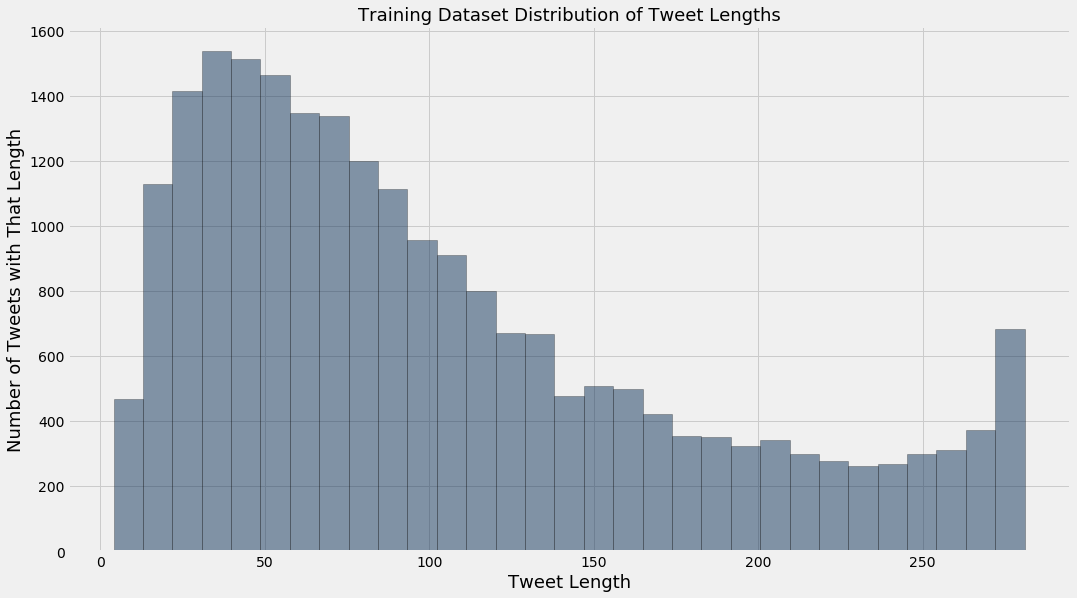

In [73]:
length_mean = length_data_for_stats.describe().Length[1]
length_std = length_data_for_stats.describe().Length[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(length_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#12355b", 
                           alpha=0.5)

# length_line = scipy.stats.norm.pdf(bins, length_mean, length_std)
# ax.plot(bins, length_line, "--", linewidth=3, color="#415d7b")

ax.set_title("Training Dataset Distribution of Tweet Lengths", fontsize=18)
ax.set_xlabel("Tweet Length", fontsize=18);
ax.set_ylabel("Number of Tweets with That Length", fontsize=18);

plt.show()

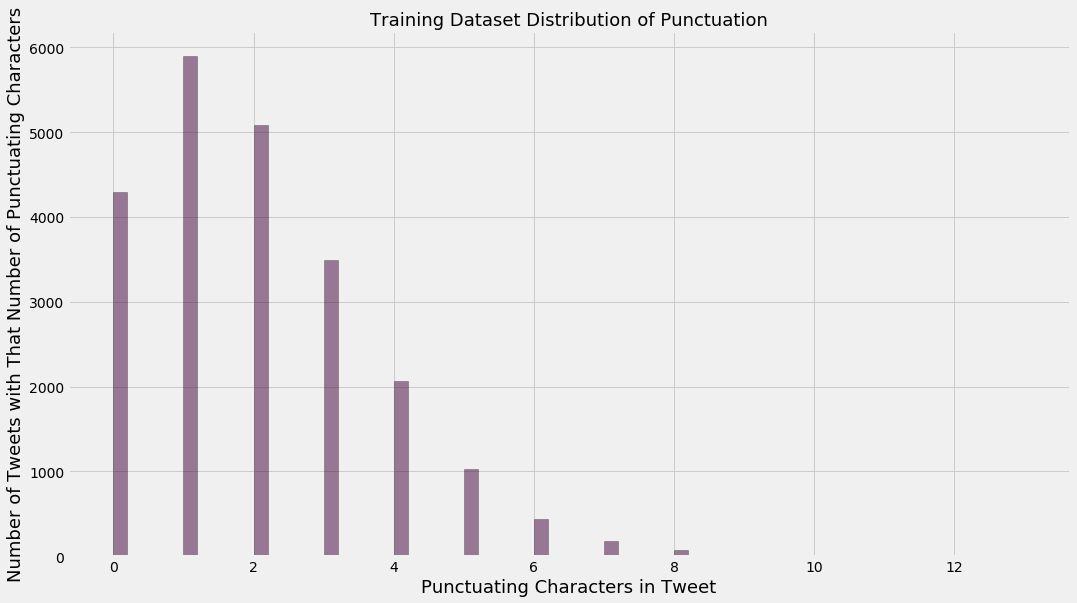

In [74]:
punctuation_mean = punctuation_data_for_stats.describe().Punctuation[1]
punctuation_std = punctuation_data_for_stats.describe().Punctuation[2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(punctuation_data, 
                           bins="scott",
                           edgecolor="black", 
                           # density=True, 
                           color="#420039",
                           alpha=0.5)

# punctution_line = scipy.stats.norm.pdf(bins, punctuation_mean, punctuation_std)
# ax.plot(bins, punctution_line, "--", linewidth=3, color="#673260")

ax.set_title("Training Dataset Distribution of Punctuation", fontsize=18)
ax.set_xlabel("Punctuating Characters in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Punctuating Characters", fontsize=18)

plt.show()

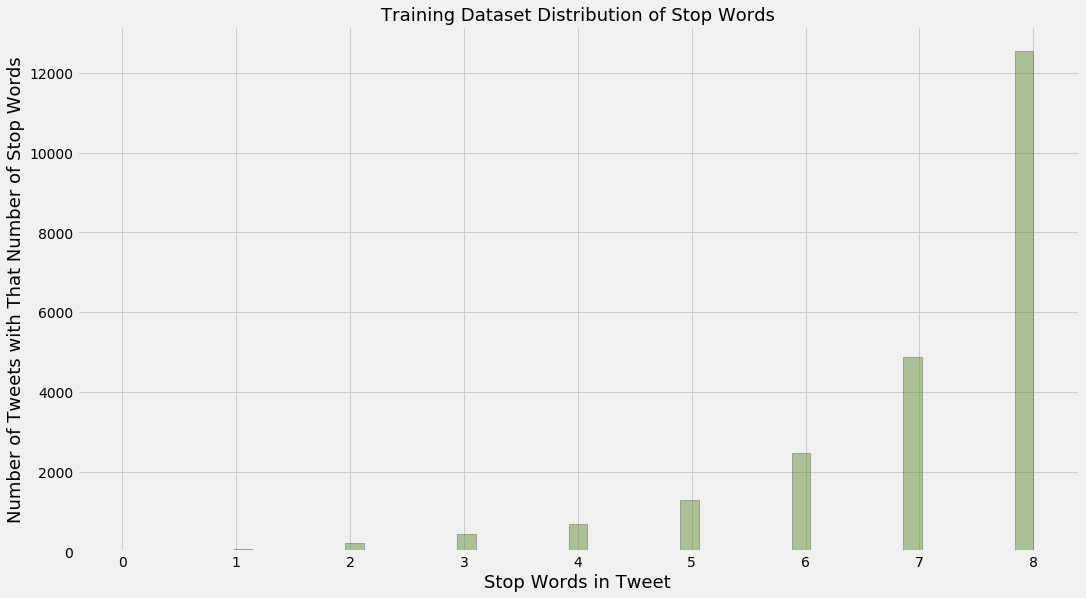

In [75]:
stop_words_mean = stop_words_data_for_stats.describe()["Stop words"][1]
stop_words_std = stop_words_data_for_stats.describe()["Stop words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(stop_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#698f3f",
                           alpha=0.5)

# stop_words_line = scipy.stats.norm.pdf(bins, stop_words_mean, stop_words_std)
# ax.plot(bins, stop_words_line, "--", linewidth=3, color="#87a565")

ax.set_title("Training Dataset Distribution of Stop Words", fontsize=18)
ax.set_xlabel("Stop Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Stop Words", fontsize=18)

plt.show()

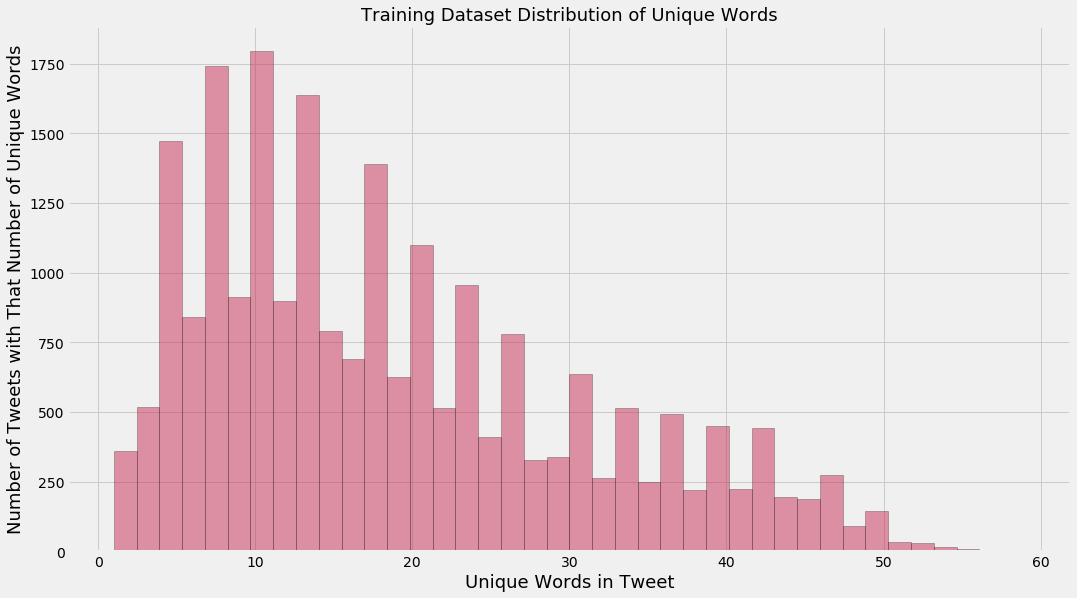

In [76]:
unique_words_mean = unique_words_data_for_stats.describe()["Unique words"][1]
unique_words_std = unique_words_data_for_stats.describe()["Unique words"][2]

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(unique_words_data, 
                           bins="scott", 
                           edgecolor="black", 
                           # density=True, 
                           color="#ca2e55",
                           alpha=0.5)

# unique_words_line = scipy.stats.norm.pdf(bins, unique_words_mean, unique_words_std)
# ax.plot(bins, unique_words_line, "--", linewidth=3, color="#d45776")

ax.set_title("Training Dataset Distribution of Unique Words", fontsize=18)
ax.set_xlabel("Unique Words in Tweet", fontsize=18)
ax.set_ylabel("Number of Tweets with That Number of Unique Words", fontsize=18)

plt.show()